In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

import tensorflow as tf

In [12]:
def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Note this function is specifically designed to plot Tensorflow training output
    Args:
      hist_df : pandas DataFrame with four columns
                For 'x' values, we will use index
                first column is accuracy
                Second column is loss
                third column is val_accuracy
                fourth column is val_loss
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6)) # instantiate plot

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]
 
    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [13]:
altName = 'all_in'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
BATCH_SIZE = 64 # batch size for training   
TRAIN_SIZE = BATCH_SIZE * 9

EPOCHS = 100 # number of cycles to run
ALPHA = 0.001 # learning rate

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (9,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

plt.rcParams.update(params) # update rcParams
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [14]:
start = -2.1
end = 2.1

### Training data

delta = 0.0005

X_train = np.arange(start, end+ delta, delta)
y_rnd = np.random.rand(X_train.shape[0]) - 0.5
y_true = 2* np.square(X_train) + 2 * np.sin(np.pi*X_train)
y_train = y_true + y_rnd*2

### Test data
X_test = np.arange(start, end+ delta, delta * 10)
y_rnd = np.random.rand(X_test.shape[0])- 0.5
y_true_test = 2* np.square(X_test) + 2 * np.sin(np.pi*X_test)
y_test = y_true_test + y_rnd*2 

In [15]:
num_examples = BATCH_SIZE * 131

X_train = X_train[:num_examples]
y_train = y_train[:num_examples]
y_true = y_true[:num_examples]

In [16]:
X_train.shape

(8384,)

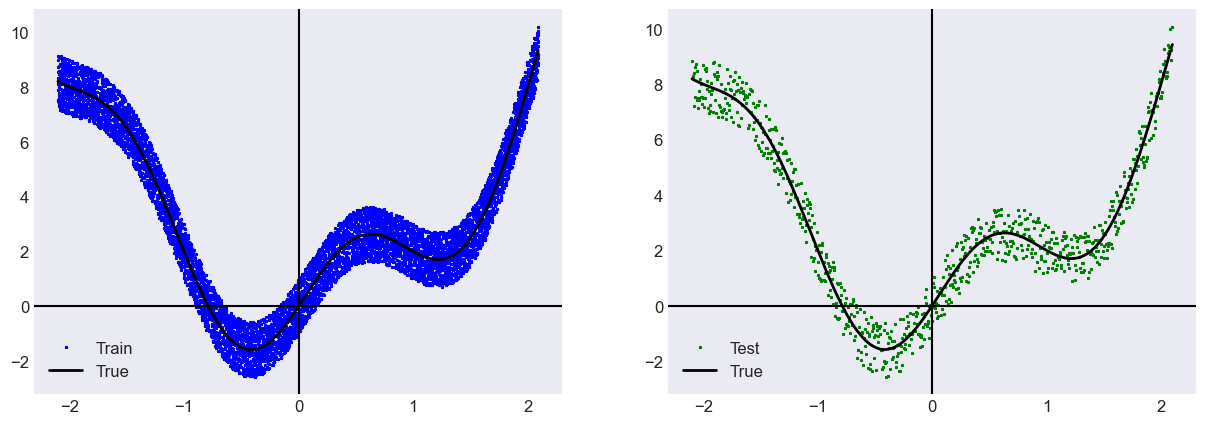

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

ax = axes[0]
ax.plot(X_train, y_train, 'b*', markersize=2, label = 'Train')
ax.plot(X_train, y_true, c = 'k', linewidth=2, label = 'True')
ax.axhline(0, c = 'k')
ax.axvline(0, c = 'k')
ax.grid()
ax.legend()

ax = axes[1]
ax.plot(X_test, y_test, 'g*', markersize=2, label = 'Test')
ax.plot(X_test, y_true_test, c = 'k', linewidth=2, label = 'True')
ax.axhline(0, c = 'k')
ax.axvline(0, c = 'k')
ax.grid()
ax.legend();

In [19]:
num_features = 1 

# initializer = tf.keras.initializers.HeNormal(seed = RANDOM_STATE)

# Define Model
# Define the input layer
input_layer = tf.keras.layers.Input(shape=(num_features,))

# Add a hidden layer with 128 neurons and ReLU activation
hidden_layer = tf.keras.layers.Dense(128, activation='relu')(input_layer)

# Add a hidden layer with 64 neurons and ReLU activation
hidden_layer = tf.keras.layers.Dense(64, activation='relu')(hidden_layer)

# Add the output layer with 10 neurons (for a classification task) and softmax activation
output_layer = tf.keras.layers.Dense(1)(hidden_layer)

# Create the model by specifying the input and output layers
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [20]:
# Compile the model with a specific optimizer, loss function, and metrics

model.compile(optimizer='adam',
              loss= 'mean_squared_error',
              metrics=['mae'])

In [21]:
# fit the model
history = model.fit(X_train, y_train,
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test,y_test],
                    epochs=EPOCHS,
                    verbose=2)

Epoch 1/100
131/131 - 1s - 10ms/step - loss: 5.9317 - mae: 1.8630 - val_loss: 2.8812 - val_mae: 1.3980
Epoch 2/100
131/131 - 0s - 906us/step - loss: 2.0703 - mae: 1.1760 - val_loss: 1.5803 - val_mae: 1.0307
Epoch 3/100
131/131 - 0s - 874us/step - loss: 1.3727 - mae: 0.9448 - val_loss: 1.2663 - val_mae: 0.8931
Epoch 4/100
131/131 - 0s - 892us/step - loss: 1.1236 - mae: 0.8401 - val_loss: 1.0530 - val_mae: 0.8098
Epoch 5/100
131/131 - 0s - 869us/step - loss: 0.9402 - mae: 0.7682 - val_loss: 0.8950 - val_mae: 0.7627
Epoch 6/100
131/131 - 0s - 891us/step - loss: 0.7850 - mae: 0.7095 - val_loss: 0.7460 - val_mae: 0.7061
Epoch 7/100
131/131 - 0s - 878us/step - loss: 0.6482 - mae: 0.6505 - val_loss: 0.6144 - val_mae: 0.6368
Epoch 8/100
131/131 - 0s - 877us/step - loss: 0.5412 - mae: 0.6007 - val_loss: 0.5049 - val_mae: 0.5858
Epoch 9/100
131/131 - 0s - 874us/step - loss: 0.4610 - mae: 0.5614 - val_loss: 0.4404 - val_mae: 0.5532
Epoch 10/100
131/131 - 0s - 962us/step - loss: 0.4204 - mae: 0.54

In [22]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,mae,val_loss,val_mae
0,5.931732,1.862996,2.881189,1.397983
1,2.070276,1.176009,1.580349,1.030665
2,1.372713,0.944826,1.266323,0.893111
3,1.123607,0.840079,1.053020,0.809784
4,0.940196,0.768158,0.895039,0.762722


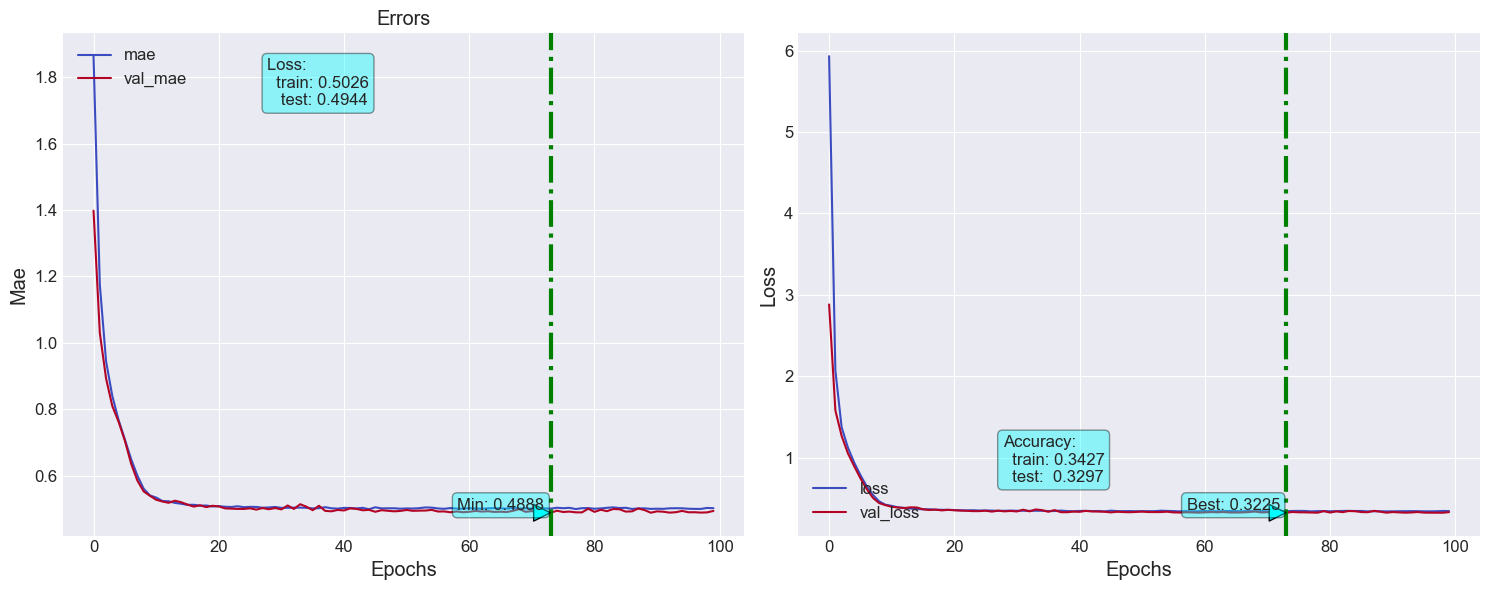

In [23]:
fn_plot_tf_hist(loss_df)

In [24]:
y_pred = model.predict(X_test)

results_df = pd.DataFrame({'pred': y_pred[:,0], 'test': y_test})

results_df['y_true'] = y_true_test

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


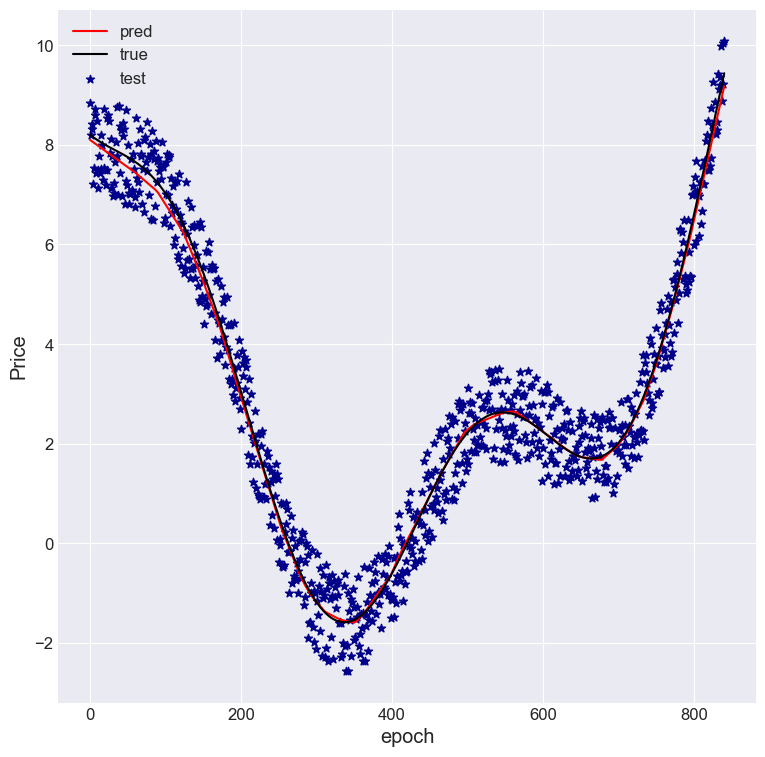

In [31]:
ax = results_df.pred.plot(c = 'r', label = 'pred');
results_df.y_true.plot(c = 'k', ax = ax, label = 'true')

plt.scatter(results_df.index, results_df.test, c='DarkBlue', marker = '*', label = 'test');
ax.set_xlabel("epoch")
ax.set_ylabel("Price")
ax.grid(True)
plt.legend()
plt.show()